<a href="https://colab.research.google.com/github/danielzt12/AD_LTEM/blob/ALCF/AD_LTEM_PyTorch_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%reload_ext autoreload

In [1]:
from routines.microscopes_fwd import *
from routines.img_helper import *

import torch
from skimage.restoration import unwrap_phase, denoise_tv_chambolle
import numpy as np
import tifffile as tif
from tifffile import imwrite, imread
from matplotlib import pyplot, colors
import sys, time
from scipy import ndimage
from scipy.fftpack import *
import gdown
from scipy.signal import fftconvolve
import fabio
import scipy.constants as physcon
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io

# will be available once we get the approval
# sys.path.append("AD_LTEM")

from torch.cuda import get_device_name
print("GPU:", get_device_name(0))

GPU: Tesla V100-PCIE-32GB


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
data_dir = "../../../01_Lorentz_Copies/ALTEM_exp_data/Cr(2)Py(16)Cr(2)/2023_06_26/512x512/TFS/nanoscale/" #"/lcrc/project/MagSim/KaynaMT/01_Lorentz_copies/NiFe/"
fls_dir = "aligned_imgj/"
file_dir = "unflip/unflip_aligned.tif"
# stck_dir = "unflip/"
anly_dir = "analysis/"

In [4]:
fls = f"{data_dir}{fls_dir}4000x_unflip.fls"
data = io.imread(f"{data_dir}{fls_dir}{file_dir}")

In [5]:
?data

Type:        ndarray
String form:
[[[ 9638575.  9695810.  9846122. ... 10348578. 10067283. 10183361.]
           [ 9765744.  9822991.  99623 <...> 91445. 14524674. 13913430.]
           [14292204. 14105116. 13487395. ... 14130851. 14216852. 14064090.]]]
Length:      19
File:        ~/bin/miniconda3/envs/ADLTEM/lib/python3.10/site-packages/numpy/__init__.py
Docstring:  
ndarray(shape, dtype=float, buffer=None, offset=0,
        strides=None, order=None)

An array object represents a multidimensional, homogeneous array
of fixed-size items.  An associated data-type object describes the
format of each element in the array (its byte-order, how many bytes it
occupies in memory, whether it is an integer, a floating point number,
or something else, etc.)

Arrays should be constructed using `array`, `zeros` or `empty` (refer
to the See Also section below).  The parameters given here refer to
a low-level method (`ndarray(...)`) for instantiating an array.

For more information, refer to the `num

In [6]:
cr_data = []
for dd in range(len(data)):
    dt = data[dd]
    cr_data.append(dt[145:145+500, 80:80+500]) #89:89+80, 130:130+80

# Create a stack of 2D arrays along a new axis (axis=0 in this case)
stack = np.stack(cr_data, axis=0)

# Save files in tif or numpy format, comment out as needed
# imwrite(f"{data_dir}{file_dir}2024-01-12_full_aligned_4k_crop500.tif",
#         stack)
# np.save(f"{data_dir}{file_dir}2024-01-12_full_aligned_4k_crop500.npy",
#         stack)

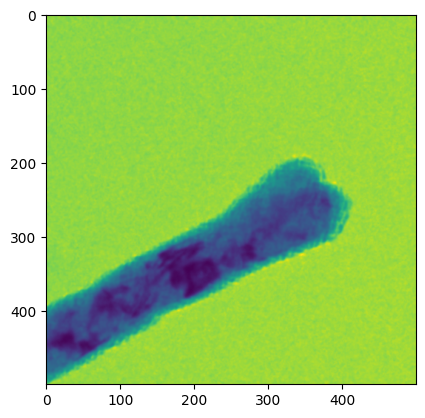

In [7]:
plt.imshow(stack[len(data)//2])

# Import Dataset

In [7]:
import sys
import os
from PIL import Image
import math
from numpy.lib import scimath
from numpy import emath

In [8]:
expdata = fabio.open(f"{data_dir}{fls_dir}{file_dir}")

In [9]:
expdata.nframes

19

In [10]:
# ((512*2.32)/4096)/512*1e3 #nm/px

5.5916/400 * 1e3 #nm/px

13.979

## Set up the Object (Sample)

In [11]:
# Dimensions of object:
Nz = expdata.nframes    # number of images in stack
Ny = expdata.data.shape[0] # length of y-axis
Nx = expdata.data.shape[1] # length of x-axis
del_px = 13.979  # nm/pixel
print("del_px:", del_px)

A_samples = np.zeros((Nz, Ny, Nx))
print("A_samples is of type:", type(A_samples))
print("A_samples is of shape:", A_samples.shape)    # verify the array


for ii in range(Nz):
  A_samples[ii] =  expdata.getframe(ii).data[:,:]#[1185:(1185+1350), 0:1350]



# np.where(A_samples == 0)
# np.where(A_samples < 0)

# print(A_samples)
A_samples = np.sqrt(np.abs(A_samples)) #np.emath.sqrt(A_samples) #np.sqrt(A_samples)

# normalize to the amplitude of the sample's experimental values
A_samples/=A_samples.mean(1).mean(1)[:,np.newaxis,np.newaxis] 

del_px: 13.979
A_samples is of type: <class 'numpy.ndarray'>
A_samples is of shape: (19, 400, 400)


In [12]:
# Step 1: Open the text file for reading
file_path = fls  # Replace with your file path
with open(file_path, 'r') as file:
    
    # Step 2: Read the lines from the file and store them in a list
    lines = file.readlines()
    
    # Step 3: Reverse the order of the lines in the list
    lines.reverse()
    
    # Step 4: Parse the numerical values from the reversed lines
    numerical_values = []
    for line in lines:
        # Assuming the numerical values are separated by spaces, you can split the line by spaces
        values = line.strip().split()
        for value in values:
            try:
                numerical_values.append(float(value))
            except ValueError:
                pass  # Ignore non-numeric values

# Now, numerical_values contains the numerical values from the text file in reverse order
print(numerical_values) # nm

[2004480.0, 1124352.0, 562176.0, 281088.0, 147456.0, 73728.0, 36864.0, 18432.0, 9216.0, 19.0]


In [13]:
numerical_values[0:-1]

[2004480.0,
 1124352.0,
 562176.0,
 281088.0,
 147456.0,
 73728.0,
 36864.0,
 18432.0,
 9216.0]

In [14]:
OF = np.array(numerical_values[0:-1])
UF = - OF
IF = 0.0
defocus = UF

defocus = np.append(arr=defocus, values=IF)
defocus = np.append(arr=defocus, values=OF[::-1])
defocus

array([-2004480., -1124352.,  -562176.,  -281088.,  -147456.,   -73728.,
         -36864.,   -18432.,    -9216.,        0.,     9216.,    18432.,
          36864.,    73728.,   147456.,   281088.,   562176.,  1124352.,
        2004480.])

In [15]:
print(len(A_samples)//2)
print(defocus[len(A_samples)//2]) # IF image, which should always be 0.0

9
0.0


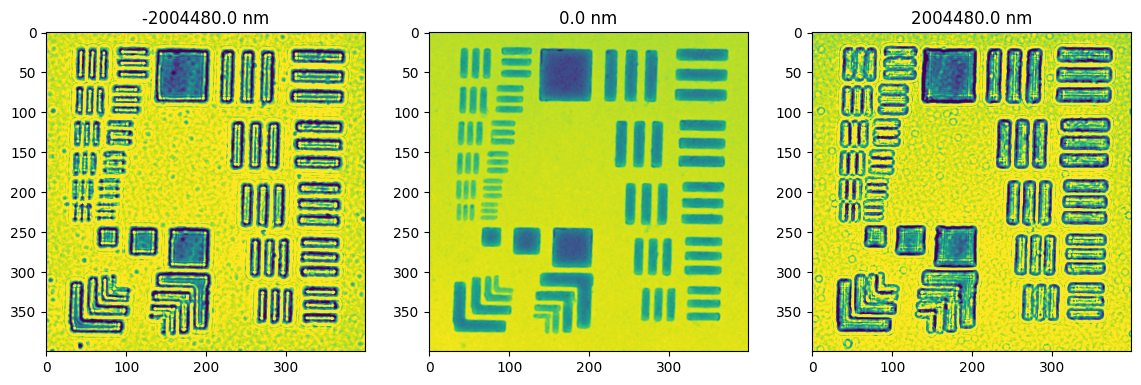

In [16]:
f, ax = pyplot.subplots(ncols=3, figsize = (14,8))
ax[0].imshow(A_samples[0], cmap='viridis', norm=colors.Normalize(A_samples[(len(A_samples)//2)].min(), A_samples[(len(A_samples)//2)].max())) #A_samples[1].min(), A_samples[1].max()))
ax[0].set_title("{0} nm".format(defocus[0]))
ax[1].imshow(A_samples[(len(A_samples)//2)], cmap='viridis', norm=colors.Normalize(A_samples[(len(A_samples)//2)].min(), A_samples[(len(A_samples)//2)].max()))
ax[1].set_title("{0} nm".format(defocus[(len(A_samples)//2)]))
ax[2].imshow(A_samples[-1], cmap='viridis', norm=colors.Normalize(A_samples[(len(A_samples)//2)].min(), A_samples[(len(A_samples)//2)].max())) #A_samples[1].min(), A_samples[1].max()))
ax[2].set_title("{0} nm".format(defocus[-1]));

In [17]:
# rewriting the microscope transfer function with tensorflow
import scipy.constants as physcon

# Dimensions of the dataset are reciprocal space (dim) dimensions
[dim,dim] = A_samples[(len(A_samples)//2)].shape
# Dimensions of real space (d2) dimensions
d2 = dim/2
print("RECIPROCAL space is:", dim, "and REAL space is:", d2)

line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = torch.tensor(np.sqrt(X**2 + Y**2) / float(dim), 
                  dtype=torch.float32, 
                  requires_grad=True, 
                  device=device)

RECIPROCAL space is: 400 and REAL space is: 200.0


In [18]:
del_px = del_px #nm/px

E = 200.0e3 # kV
Cs = 1.0e6    
Cc = 5.0e6
Ca = 0.0e6
phi_a = 0.0
def_spr = 120

epsilon = 0.5 * physcon.e / physcon.m_e / physcon.c**2
lam = physcon.h * 1.0e9 / np.sqrt(2.0 * physcon.m_e * physcon.e) / np.sqrt(E + epsilon * E**2)
gamma = 1.0 + physcon.e * E / physcon.m_e / physcon.c**2
sigma = 2.0 * np.pi * physcon.m_e * gamma * physcon.e * lam * 1.0e-18 / physcon.h**2

scale1 = 1
scale2 = 100

In [19]:
lam = lam / del_px
cs = Cs / del_px
ca = Ca / del_px
phi = 0
spread = def_spr / del_px

In [20]:
def getTF(defoc, theta_c):

  def_val = defoc * scale1 / del_px

  theta_c = torch.pow(10, theta_c/scale2)

  p1 = np.pi * lam * (def_val + ca * np.cos(2.0 * (phi - phi_a))) # tensor
  p2 = np.pi * cs * lam**3 * 0.5 
  p3 = 2.0 * (np.pi * theta_c * spread)**2  # a tensor
  p4 = (np.pi * lam * spread)**2
  p5 = np.pi**2 * theta_c**2 / lam**2  # a tensor
  p6 = cs * lam**3   
  p7 = def_val * lam  # a tensor
 
  u = 1.0 + p3 * qq**2 
  chiq = -p1 * qq**2 + p2 * qq**4  
  es_arg = 1.0/(2.0*u) * p4 * qq**4   
  et_arg = torch.multiply(1.0/u, torch.multiply(p5, (p6 * qq**3 - torch.multiply(p7,qq) )**2 ) )  # a tensor

  dampenv = torch.exp(es_arg-et_arg)   # a tensor
  transfer_function = torch.fft.fftshift(torch.multiply(torch.complex(torch.cos(chiq),-torch.sin(chiq)), dampenv), dim=(1,2))
  
  return transfer_function

In [21]:
def compute_loss():
  tf_obj = guess_amplitude * torch.exp(1j*guess_phase)
  cal_data = torch.fft.ifft2(torch.fft.fft2(tf_obj)*getTF(defoc, theta_c))
  cal_data = torch.abs(cal_data)
  cal_data /= torch.mean(cal_data.clone(), dim=(1,2), keepdims=True)

  return torch.mean((cal_data - exp_data)**2)

In [22]:
torch.autograd.set_detect_anomaly(True)

In [23]:
def training_loop(optimizer, n=10000):
    "Training loop for torch model."
    losses = []
    for i in range(n):
        loss = compute_loss()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.cpu().detach().numpy())  
        if i>0 and not i%10000:
          print(loss, theta_c)
    return losses

## BE SURE TO MODIFY GUESS AMPLITUDE AND GUESS PHASE in variable A_samples[n = "IF Image"]

In [24]:
?denoise_tv_chambolle

Signature:
denoise_tv_chambolle(
    image,
    weight=0.1,
    eps=0.0002,
    max_num_iter=200,
    multichannel=False,
    *,
    channel_axis=None,
)
Docstring:
Perform total-variation denoising on n-dimensional images.

Parameters
----------
image : ndarray of ints, uints or floats
    Input data to be denoised. `image` can be of any numeric type,
    but it is cast into an ndarray of floats for the computation
    of the denoised image.
weight : float, optional
    Denoising weight. The greater `weight`, the more denoising (at
    the expense of fidelity to `input`).
eps : float, optional
    Relative difference of the value of the cost function that
    determines the stop criterion. The algorithm stops when:

        (E_(n-1) - E_n) < eps * E_0

max_num_iter : int, optional
    Maximal number of iterations used for the optimization.
multichannel : bool, optional
    Apply total-variation denoising separately for each channel. This
    option should be true for color images, oth

In [25]:
?torch.optim.Adam

Init signature:
torch.optim.Adam(
    params,
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0,
    amsgrad=False,
    *,
    foreach: Optional[bool] = None,
    maximize: bool = False,
    capturable: bool = False,
)
Docstring:     
Implements Adam algorithm.

.. math::
   \begin{aligned}
        &\rule{110mm}{0.4pt}                                                                 \\
        &\textbf{input}      : \gamma \text{ (lr)}, \beta_1, \beta_2
            \text{ (betas)},\theta_0 \text{ (params)},f(\theta) \text{ (objective)}          \\
        &\hspace{13mm}      \lambda \text{ (weight decay)},  \: \textit{amsgrad},
            \:\textit{maximize}                                                              \\
        &\textbf{initialize} :  m_0 \leftarrow 0 \text{ ( first moment)},
            v_0\leftarrow 0 \text{ (second moment)},\: \widehat{v_0}^{max}\leftarrow 0\\[-1.ex]
        &\rule{110mm}{0.4pt}                                                 

In [26]:
## BE SURE TO MODIFY GUESS AMPLITUDE AND GUESS PHASE in variable A_samples[n = "IF Image"]

selection = [0,1,2,9,16,17,18] #[6, 7, 8, 9, 10, -10, -9, -8, -7,]#[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]

exp_data = torch.from_numpy(A_samples[selection].astype(np.float32)).to(device)

# initialize the amplitude as the square root of the in focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = torch.tensor(denoise_tv_chambolle(A_samples[(len(A_samples)//2)], 
                                                    weight=0.025, 
                                                    channel_axis=False), 
                                dtype=torch.float32, 
                                requires_grad=False, 
                                device=device)

# initialize the phase as 0.5 everywhere
guess_phase = torch.tensor(np.zeros(A_samples[(len(A_samples)//2)].shape)+0.5, 
                           dtype=torch.float32, 
                           requires_grad=True, 
                           device=device) 
print(guess_phase.type(), guess_phase.dtype, guess_phase)

defoc = torch.tensor(defocus[selection][:, np.newaxis, np.newaxis]/scale1, 
                     dtype=torch.float32, 
                     requires_grad=False, 
                     device=device)
print(defoc)
theta_c = torch.tensor(-500, dtype=torch.float32, requires_grad=False, device=device) 

opt = torch.optim.Adam([guess_phase], lr=0.025)

torch.cuda.FloatTensor torch.float32 tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        ...,
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
       device='cuda:0', requires_grad=True)
tensor([[[-2004480.]],

        [[-1124352.]],

        [[ -562176.]],

        [[       0.]],

        [[  562176.]],

        [[ 1124352.]],

        [[ 2004480.]]], device='cuda:0')


In [27]:
losses = training_loop(opt, n=200000)

tensor(0.0032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-500., device='cuda:0')
tensor(0.0032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-500., device='cuda:0')
tensor(0.0032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-500., device='cuda:0')
tensor(0.0032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-500., device='cuda:0')
tensor(0.0032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-500., device='cuda:0')
tensor(0.0032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-500., device='cuda:0')
tensor(0.0032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-500., device='cuda:0')
tensor(0.0032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-500., device='cuda:0')
tensor(0.0032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-500., device='cuda:0')
tensor(0.0032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-500., device='cuda:0')
tensor(0.0032, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-500., device='cuda:0')
tensor(0.0032, device='cuda:0', 

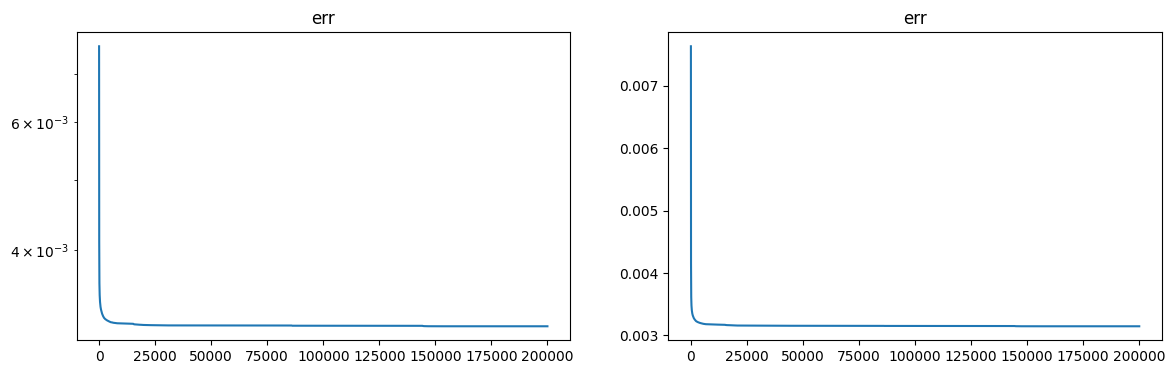

In [32]:
f, ax = pyplot.subplots(ncols=2, figsize = (14,4))
ax[0].semilogy(losses)
ax[0].set_title("err")
ax[1].plot(losses)
ax[1].set_title("err");

In [29]:
np.save(file=f"{data_dir}{anly_dir}RMAD-losses_expPIA_nanoscale-029.npy", #f"{data_dir}{file_dir}{anly_dir}2024-03-10_RMAD_losses_(1-21)-4k.npy",
        arr=losses,
        allow_pickle=True,
        )

In [33]:
result_phase = guess_phase.cpu().detach().numpy()
result_phase -= result_phase.mean()

In [31]:
np.save(file=f"{data_dir}{anly_dir}RMAD-tphi_expPIA_nanoscale-029.npy", #f"{data_dir}{file_dir}{anly_dir}2024-03-10_RMAD_phase_(1-21)-4k.npy",
        arr=result_phase,
        allow_pickle=True,
       )

In [41]:
result_phase

array([[-6.185575 , -6.3071   , -6.424532 , ..., -5.7640147, -5.9059324,
        -6.0377407],
       [-5.9848914, -6.1048784, -6.231345 , ..., -5.5429463, -5.6898074,
        -5.840288 ],
       [-5.7701964, -5.894292 , -6.02922  , ..., -5.3363485, -5.489477 ,
        -5.6385674],
       ...,
       [-6.7419   , -6.864968 , -6.9883666, ..., -6.3781786, -6.4953833,
        -6.612323 ],
       [-6.541259 , -6.6722784, -6.796426 , ..., -6.1645823, -6.3058114,
        -6.417717 ],
       [-6.356955 , -6.4868345, -6.6118264, ..., -5.9642615, -6.1043935,
        -6.2268963]], dtype=float32)

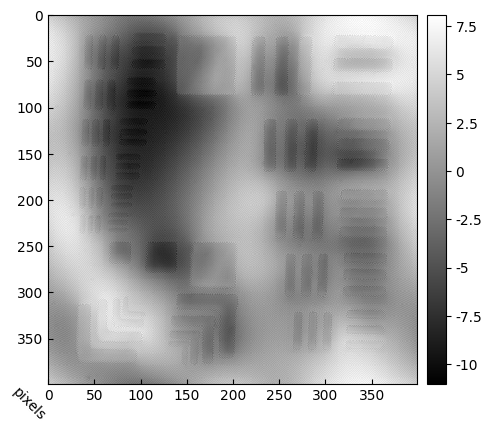

In [34]:
show_im(result_phase)

# imwrite(f"{data_dir}{file_dir}{anly_dir}2024-03-10_RMAD_phase_(1-21)-4k.tif", result_phase)

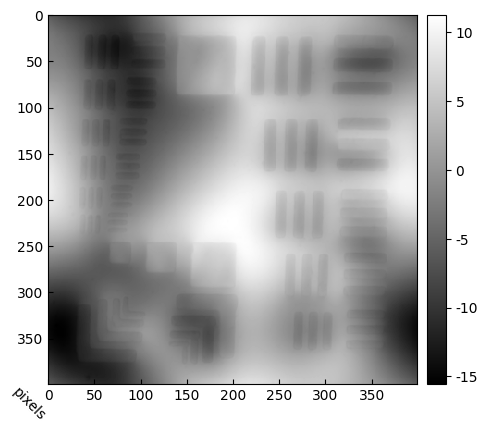

In [43]:
show_im(unwrap_phase(result_phase))

In [79]:
# from skimage.restoration import unwrap_phase

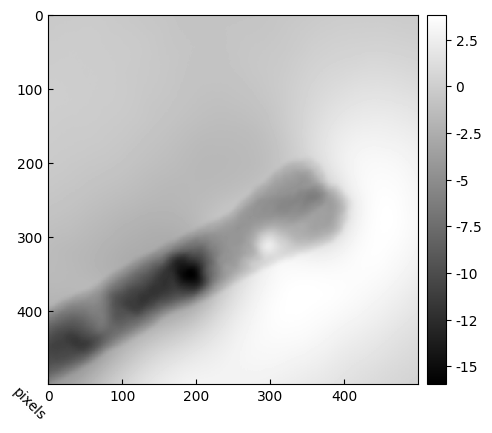

In [54]:
cropped_result = result_phase[145:145+500, 80:80+500]
show_im(cropped_result)

13.979


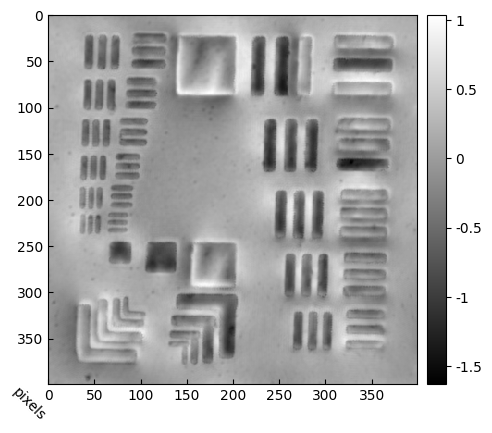

In [44]:
from routines.img_helper import *
p = result_phase
fftp = get_fft(p)
del_px = del_px
print(del_px)

filter_lf = 1000 #2500 # nm
filter_hf = 105 # 2500 # nm

dim_y, dim_x = p.shape

x_sampling = y_sampling = 1 / del_px  # [pixels/nm]
u_max = x_sampling / 2
v_max = y_sampling / 2
u_axis_vec = np.linspace(-u_max / 2, u_max / 2, dim_x)
v_axis_vec = np.linspace(-v_max / 2, v_max / 2, dim_y)
u_mat, v_mat = np.meshgrid(u_axis_vec, v_axis_vec)
r = np.sqrt(u_mat**2 + v_mat**2)  # nm

if filter_lf is not None:
    inverse_gauss_filter = 1 - np.exp(-1 * (r * filter_lf) ** 2)
else:
    inverse_gauss_filter = np.ones_like(r)
if filter_hf is not None:
    gauss_filter = np.exp(-1 * (r * filter_hf) ** 2)
else:
    gauss_filter = np.ones_like(r)
bp_filter = inverse_gauss_filter * gauss_filter

bp_fftp = fftp*bp_filter
kp = get_ifft(bp_fftp).real

show_im(kp)

In [59]:
?plt.imshow

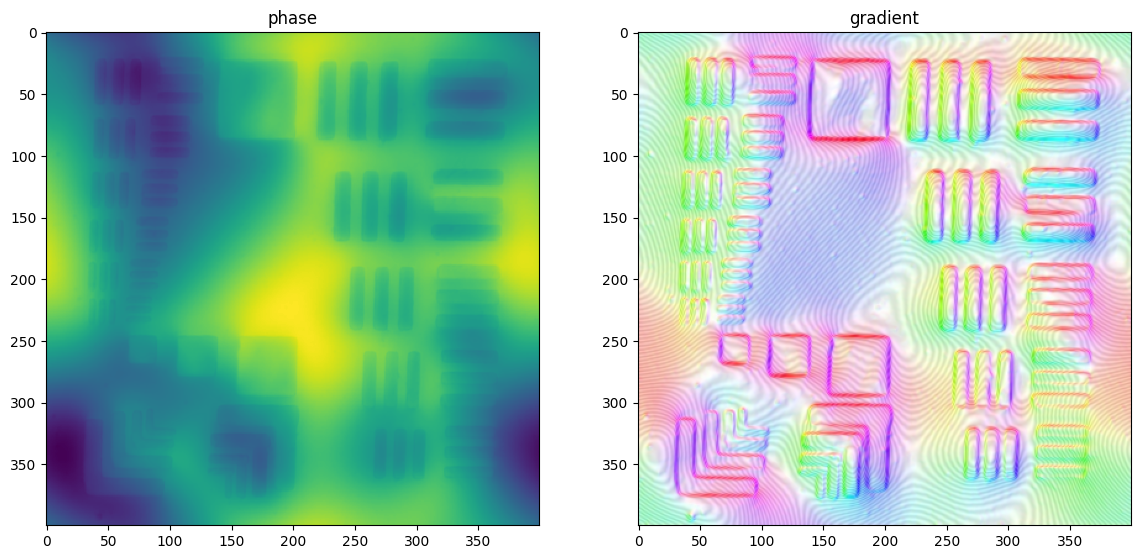

In [44]:
# from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = pyplot.subplots(ncols=2, 
                        figsize = (14,8))

ax[0].imshow(result_phase, 
             interpolation='none', 
             cmap='viridis',
#              origin="lower",
             )
ax[0].set_title("phase")

t2 = np.copy(result_phase)
t2=ndimage.gaussian_filter(t2-np.mean(t2),
                           sigma=1.0,
                           order=0)

gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)

rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)

ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), 
             cmap='gray', 
             alpha=0.1, 
#              vmin=-1, 
#              vmax=1,
#              origin="lower",
            )
ax[1].set_title("gradient");
# plt.savefig("/home/ktrujillo/Lorentz_Copies/ADLTEM_analysis/mumax3_usaf_nano0.7_1.4nmppx_lr0.025_sigma2.5.png")
# plt.savefig("/home/ktrujillo/Lorentz_Copies/ADLTEM_analysis/exp_usaf_micro_lr0.00025_sigma2.5.png")

## Import RAW DATA Individually

In [ ]:
from skimage import io
p = io.imread("/home/ktrujillo/Lorentz/Kayna/ALTEM/Py(18)Pt(2)C(1)/2023_05_18/TIE/usaf_micro/aligned_imgj/images/RMAD/usaf_micro_AD_RAW.tiff")

show_im(p)
plt.imshow(p, cmap="gray")
